In [5]:
from Dino_Images import *

# Source files
DI = Dino_Images()

## Background Removal

In this section, we want to compare different background remove procedure for get the best result. The reason behind segementing the background from the object is to make sure we only perform 3d reconstruction on the object instead of everything else. 

### Historgram-Based Naive Segmentation 

One of the naive way to do it is to select the points with a cutoff threshold. Here we applied a color threshold on every pixels on the image. Pixels which have color intensity $r, g, b$ which $r + g + b < threshold$ is considered the background. 

In [12]:
def background_remover_naive(img, threshold = 0.4):

    h,w,_ = np.shape(img)
    mask = np.where(np.sum(img, axis = 2) > threshold, 1, 0)
    inbound_idx = np.where(mask == 1)
    points = np.array([inbound_idx[1], inbound_idx[0]]).T
    
    return mask, points

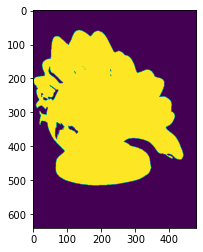

In [13]:
mask_naive, points = background_remover_naive(rotate(DI.image_list[0], 90, resize = True))
plt.imshow(mask)

### Stereo Depth Matching Segmentations 

Since we have stereo images, one of the naive way of distinguishing background from object is to use the depth detection algorithm, in hope that the background is labeled in different depth than the object. Since the relative position between stereo camera point is small, we assume them to be at the same position. Hence, we can use the ransec on find the homogenis metrix for wrapping second image to the same plane. Here we used a simple disparity calculation using the distance between points in image plane corresponding to the scene point 3D and their camera center. We apply the epiline constraint to find matching points along the same epiline. 

In [3]:
def background_remover_depth(imgL, imgR, TL, TR, threshold=0.0005, min_d=5):
    
    T_abs = TR - TL
    assert np.all(np.abs(T_abs) < 1), "The absolute translation is too small"
    
    # Convert image into uint8 with greyscale
    imgL_grey = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY) 
    imgR_grey = cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY) 
    
    # Match points using corner harris
    keypointsL = corner_peaks(corner_harris(imgL_grey), threshold_rel=threshold, min_distance=min_d)
    keypointsR = corner_peaks(corner_harris(imgR_grey), threshold_rel=threshold, min_distance=min_d)

    extractor = BRIEF()

    extractor.extract(imgL_grey, keypointsL)
    keypointsL = keypointsL[extractor.mask]         
    descriptorsL = extractor.descriptors

    extractor.extract(imgR_grey, keypointsR)
    keypointsR = keypointsR[extractor.mask]
    descriptorsR = extractor.descriptors

    matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)
    
    # Compute the imR projection
    data = (np.flip(keypointsR[matchesLR[:,1]], axis=1), np.flip(keypointsL[matchesLR[:,0]], axis=1))
    model_robust, inliers = ransac(data, ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=5000)

    imR_rpj = warp(imgR_grey, model_robust.inverse)
    
    # Compute disparity map
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
    disparity = stereo.compute(imgL_grey, img_as_ubyte(imR_rpj))
    
    return disparity + 16, imR_rpj

In [10]:
# Test on the first pair of images
imgL_rotate = img_as_ubyte(rotate(DI.image_list[0], 90, resize = True))
imgR_rotate = img_as_ubyte(rotate(DI.image_list[1], 90, resize = True))
mask_depth, imR_rpj = background_remover_depth(imgL_rotate, imgR_rotate, DI.T_Matrix[0], DI.T_Matrix[1])

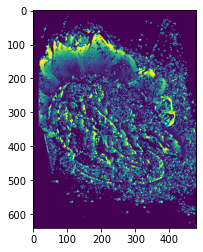

In [11]:
plt.imshow(mask_depth)

### K-Means Segamentation

Here we implemented the K-means segementation algorithm based on three pixels features, namely the intensity, x, and y location. We applied $\epilson$ on the x and y location for lowering the penalty on location inconsistency. Essentially we use $k = 3$, and initialize the k-means center by selecting the top-left, bottom-right and centre pixel. By doing so, we ensures that the object is always located in the center clustering.  

In [6]:
def background_remover_k_clustering(img, Kinit = None, epi = 0.3):
    
    # Convert to integer and gray scale
    img_int = img_as_ubyte(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)) 

    # Create the lxy list 
    x, y = np.ogrid[:img_int.shape[1], :img_int.shape[0]]
    x_mtx, y_mtx = np.meshgrid(x, y)
    img_lxy = np.dstack((img_int, x_mtx * epi, y_mtx * epi))
    img_lxy_reshape = img_lxy.reshape(-1, 3)
    
    # Create the K init if not provided
    if not Kinit:
        h, w = img_int.shape
        Kinit = np.array([[0, 0, 0], [0, w, h], [255/2, w/2, h/2]])
        
    kmeans = KMeans(init=Kinit, n_clusters=3).fit(img_lxy_reshape)
    
    return kmeans.labels_.reshape(img_int.shape[0], img_int.shape[1])

/Users/jackxu/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


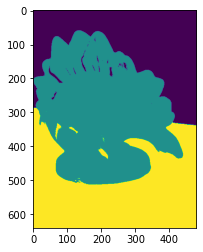

In [7]:
mask_km = background_remover_k_clustering(rotate(DI.image_list[0], 90, resize = True))
plt.imshow(mask_km)

### Auto Background Removel by Adobe

We also used the auto background segementation algorithm provided in Adobe Photoshop. This approch is consisted with using a deep neural network encoder and decoder structure. The network is trained with a data set of 49,300 images, and the algorithm seems to have learned well. https://arxiv.org/pdf/1703.03872.pdf. The sturecture of the neural network is as followed:

We use the Adobe photoshop action tools to automate the entire background removal process in one click. Some of the result are shown as followed: